<a href="https://colab.research.google.com/github/yuliiabosher/Adam_Smith_project/blob/main/Visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import collections
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
import itertools

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
def month_to_number(month):
  months = {"january": "1", "february": "2", "march": "3", "april": "4", "may": "5", "june": "6", "july": "7", \
            "august": "8", "september": "9", "october": "10", "november": "11", "december": "12"}
  month = month.lower()
  numerical = months[month]
  return numerical

def to_date(string):
  elements = string.split(',')
  year = elements[-1].strip()
  month, day = elements[-2].split()
  month = month_to_number(month)
  date = f'{year}-{month}-{day}'
  return date

(array([1., 2., 4., 3., 4., 1., 2., 1., 2., 3.]),
 array([16785., 17049., 17313., 17577., 17841., 18105., 18369., 18633.,
        18897., 19161., 19425.]),
 <BarContainer object of 10 artists>)

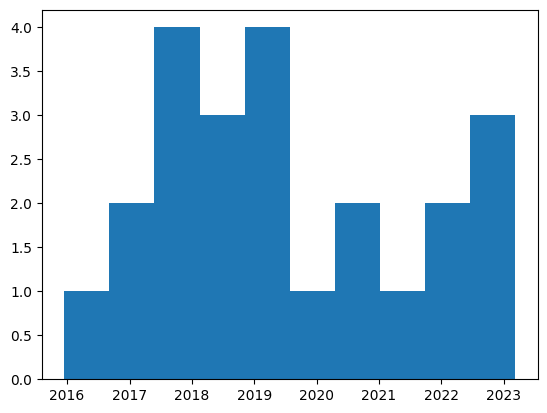

In [4]:
def clean_df(df):
  df = pd.read_excel(df, skiprows=1)
  df = df.fillna('n/a')
  df = df.drop(df[df['Mention of Adam smith'].str.contains('NA')].index)
  df = df.drop(df[df['Mention of Adam smith'].str.contains('n/a')].index)
  df.columns = ['Date', 'Extract', 'Notes', 'Notes2', 'About Adam Smith', 'Rep']
  dates = []
  for index, row in df.iterrows():
    dates.append(to_date(row['Date']))
  df['Date'] = dates
  df['Date'] = pd.to_datetime(df['Date'])
  df = df.set_index('Date').sort_index()
  return df
df = clean_df('https://github.com/yuliiabosher/Adam_Smith_project/raw/main/adam_smith.xlsx')
plt.hist(df.index)

In [5]:
def tokenize_df(df):
  tokens = [nltk.word_tokenize(row['Extract']) for index, row in df.iterrows()]
  return tokens

token_list = tokenize_df(df)
print(token_list[0][:10])

['It', 'was', 'on', 'this', 'very', 'day', ',', 'December', '16', ',']


In [6]:
def preprocess_tokens(list_of_lists):
  lower_tokens = [[t.lower() for t in list_of_tokens] for list_of_tokens in list_of_lists for t in list_of_tokens]
  alpha_only = [[t for t in token_list if t.isalpha()] for token_list in lower_tokens]
  no_stops = [[t for t in alpha_list if t not in nltk.corpus.stopwords.words('english')] for alpha_list in alpha_only]
  wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
  lemmatized = [[wordnet_lemmatizer.lemmatize(t) for t in no_stops_list] for no_stops_list in no_stops]
  return lemmatized

preprocessed = preprocess_tokens(token_list)
print(preprocessed[0][:10])

['day', 'december', 'patriot', 'boston', 'harbor', 'expressed', 'displeasure', 'foreign', 'power', 'influence']


In [11]:
def create_corpus(preprocessed_data):
  dictionary = Dictionary(preprocessed)
  corpus = [dictionary.doc2bow(article) for article in preprocessed]
  return dictionary, corpus

dictionary, corpus = create_corpus(preprocessed)
print(corpus[0][:10])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 3), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


In [12]:
def word_count_desc(corpus):
  total_word_count = collections.defaultdict(int)
  for word_id, word_count in itertools.chain.from_iterable(corpus):
      total_word_count[word_id] += word_count
  sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True)
  return sorted_word_count

sorted_word_count = word_count_desc(corpus)
print(sorted_word_count[:10])

[(33, 2457), (0, 2318), (119, 1342), (17, 1196), (45, 1080), (104, 1047), (38, 1031), (135, 968), (23, 878), (166, 821)]


In [13]:
for word_id, word_count in sorted_word_count[:20]:
    print(dictionary.get(word_id), word_count)

smith 2457
adam 2318
wealth 1342
free 1196
country 1080
people 1047
would 1031
year 968
market 878
capitalism 821
nation 801
like 603
wrote 601
great 529
said 527
society 504
political 495
competition 456
quote 429
world 427


In [16]:
def calculate_weight_of_words(corpus):
  try:
    tfidf = TfidfModel(corpus)
    all_tfidf_weights = []
    i=1
    while tfidf[corpus[i]]:
      tfidf_weights = tfidf[corpus[i]]
      sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)
      all_tfidf_weights.append(sorted_tfidf_weights)
      i+=1
    return all_tfidf_weights
  except IndexError:
    return all_tfidf_weights

all_tfidf_weights = calculate_weight_of_words(corpus)
print(all_tfidf_weights)

[[(4, 0.4764702349667554), (3, 0.3176468233111702), (2, 0.1588234116555851), (8, 0.1588234116555851), (9, 0.1588234116555851), (11, 0.1588234116555851), (12, 0.1588234116555851), (14, 0.1588234116555851), (15, 0.1588234116555851), (16, 0.1588234116555851), (19, 0.1588234116555851), (20, 0.1588234116555851), (26, 0.1588234116555851), (27, 0.1588234116555851), (28, 0.1588234116555851), (32, 0.1588234116555851), (34, 0.1588234116555851), (35, 0.1588234116555851), (36, 0.1588234116555851), (39, 0.1588234116555851), (6, 0.1537062767308486), (7, 0.13663900968686055), (29, 0.13663900968686055), (1, 0.1233676214623409), (24, 0.12253228512384305), (37, 0.12253228512384305), (13, 0.11853682678083187), (31, 0.11751887244322412), (5, 0.11409816693055135), (21, 0.1104339717632562), (30, 0.1080500376907654), (22, 0.10741750501136631), (25, 0.10741750501136631), (18, 0.10071757015203703), (10, 0.08178064460273209), (23, 0.05955252431974684), (17, 0.05062123353342408), (38, 0.032254109004799594), (33,

In [17]:
for i in all_tfidf_weights:
  for term_id, weight in i:
    print(dictionary.get(term_id), weight)

Streaming output truncated to the last 5000 lines.
television 0.3393516494690018
le 0.29697762479581424
percent 0.25828371763589875
world 0.23285439399062635
country 0.17497423986582397
adopted 0.1696758247345009
astray 0.1696758247345009
division 0.1696758247345009
equivalent 0.1696758247345009
far 0.1696758247345009
find 0.1696758247345009
honest 0.1696758247345009
labour 0.1696758247345009
led 0.1696758247345009
medium 0.1696758247345009
middle 0.1696758247345009
misguided 0.1696758247345009
news 0.1696758247345009
newspaper 0.1696758247345009
poorest 0.1696758247345009
success 0.1696758247345009
huge 0.14052880261390427
actually 0.1392938691521748
know 0.1351512000695159
day 0.13262383140967116
today 0.13019307407308825
good 0.12914185881794937
talked 0.12658741605171256
look 0.11859795635981846
class 0.11664096887711066
trade 0.10130376747351456
going 0.09400032647221258
capitalism 0.08402560405660493
people 0.0772224901513902
smith 0.002797463618688316
adam 0.0003430271258807003
